In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import scipy
import itertools
from scipy.special import log_softmax
from scipy.stats.stats import pearsonr

from alignmenttools.MultipleSequenceAlignment import MultipleSequenceAlignment as MSA
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS, Predictive

rng = np.random.default_rng()

In [2]:
alphabet = 'ACDEFGHIKLMNPQRSTVWY'
the_rest = 'BJOUXZ'
gap = '-'

onehot_dicts = [{}]*2

#Making dictionaries for conversion from letters to one-hot dictionaries
#if treating gaps as characters
onehot_dicts[0] = {letter: ([0] * (len(alphabet)+1)) for letter in the_rest}
for i, letter in enumerate(gap + alphabet): #check to see where gaps come in the hi, Jij matrix - I believe it's at the start
    onehot_dicts[0][letter] = [0] * i + [1] + [0] * (len(alphabet) - i)

#if ignoring gaps
onehot_dicts[1] = {letter: ([0] * len(alphabet)) for letter in the_rest + gap}
for i, letter in enumerate(alphabet):
    onehot_dicts[1][letter] = [0] * i + [1] + [0] * (len(alphabet) - i - 1)

#if input seq is numeric
onehot_dicts_numeric = [[[0] * i + [1] + [0] * (len(alphabet) - i) for i in range(len(alphabet)+1)], 
                [[0] * i + [1] + [0] * (len(alphabet) - i - 1) for i in range(len(alphabet))]]

def onehot_seqs(seq, gap_ignore = 1, is_numeric = False):
    '''
    Convert letter sequences to onehot
    '''
    if is_numeric:
        onehot_dict = onehot_dicts_numeric[gap_ignore]
    else:
        onehot_dict = onehot_dicts[gap_ignore]
    ans = []
    for letter in seq:
        ans += onehot_dict[letter]
            
    return np.array(ans)

def hi_to_onehot(hi):
    '''
    Convert 2D (L x alphabet_size) h_i (fields) matrix to 2D (L*alphabet_size x 1) using onehot
    '''
    return hi
#    return torch.tensor(hi.reshape(-1, 1), device = device, dtype = torch.float32)

def Jij_to_onehot(Jij):
    '''
    Convert 4D (L x L x alphabet_size x alphabet_size) J_ij (pairwise terms) matrix to 2D (L*alphabet_size x L*alphabet_size) using onehot
    '''
    return Jij.swapaxes(2, 1).reshape(Jij.shape[0], Jij.shape[-1], Jij.shape[0] * Jij.shape[-1])

In [5]:
def load_data(seq_name, hi_name, Jij_name, seq_is_numeric):
    hi = np.load(hi_name)
    Jij = np.load(Jij_name)
    seq = np.load(seq_name)
    L, alphabet_size = hi.shape
    gap_ignore = (alphabet_size == len(alphabet))

    seq = onehot_seqs(seq, gap_ignore, seq_is_numeric)
    hi = hi_to_onehot(hi)
    Jij = Jij_to_onehot(Jij)
    
    return seq, hi, Jij, L, alphabet_size, gap_ignore
    
def gibbs_transition(sne_onehot, hi_onehot, Jij_onehot, L, alphabet_size, gap_ignore):
    sweep_order = rng.permutation(range(L))
    seq_onehot = np.copy(sne_onehot)
    for i in sweep_order:
        pll_i_dist = np.exp(log_softmax((hi_onehot[i] + Jij_onehot[i] @ seq_onehot)))
        new_aa = rng.choice(alphabet_size, p = pll_i_dist)
        seq_onehot[i*alphabet_size:(i+1)*alphabet_size] = onehot_dicts_numeric[gap_ignore][new_aa]
    return seq_onehot    

def PLL(msa, hi_onehot, Jij_onehot):
    L, alphabet_size = hi_onehot.shape
    hi_onehot = np.expand_dims(hi_onehot, -1)
    UI = hi_onehot + Jij_onehot @ msa
    ll_energies = log_softmax(UI, axis = 1)
    return np.sum((ll_energies * msa.reshape(L, alphabet_size, -1)), axis = (-3, -2))

def to_records(seqs, seq_ids, L, alphabet_size):
    records = []
    if alphabet_size == len(alphabet):
        alph_use = alphabet
    else:
        alph_use = gap + alphabet
    for (seq, seq_id) in zip(seqs, seq_ids):
        s = ''
        for i in range(L):
            #doeesn't work if has gaps
            s += alph_use[int(np.where(seq[i*alphabet_size:(i+1)*alphabet_size] == 1)[0])]
        records.append(SeqRecord(Seq(s), id = seq_id))
    return records
    

def write_fasta(seqs, seq_ids, name, L, alphabet_size):
    '''
    Writes msa into fasta file of given name
    '''
    records = to_records(seqs, seq_ids, L, alphabet_size)
    with open(name, 'w') as f:
        SeqIO.write(records, f, 'fasta')

def run_gibbs(sne_name, hi_name, Jij_name, seq_is_numeric = True, 
              sample_iters = 10000, burn = 100, skip = 100, plot_plls = True):
    seed, hi, Jij, L, alphabet_size, gap_ignore = load_data(sne_name, hi_name, Jij_name, seq_is_numeric)
    
    if skip < 1:
        skip = 1
    
    seq = seed
    seqs = []
    seq_ids = []
    for i in range(burn):
        seq = gibbs_transition(seq, hi, Jij, L, alphabet_size, gap_ignore)
    
    for i in range(sample_iters):
        seq = gibbs_transition(seq, hi, Jij, L, alphabet_size, gap_ignore)
        if i % skip == 0:
            seqs.append(seq)
            seq_ids.append('sample_' + str(i))
            
    if plot_plls:
        plt.plot(range(burn, burn + sample_iters, skip), PLL(np.array(seqs).T, hi, Jij))
        plt.xlabel('iter')
        plt.ylabel('Log pseudolikelihood')
        plt.axhline(y=PLL(np.expand_dims(seed, -1), hi, Jij)[0], color='r', linestyle='--')
    
    write_fasta(seqs, seq_ids, sne_name.split('.')[0] + '_sampled_seqs.fa', L, alphabet_size)
    
    return seqs

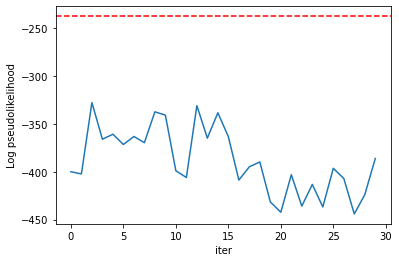

In [6]:
hi_name = 'hi_example.npy'
Jij_name = 'Jij_example.npy'
sne_name = 'seq_numeric_example.npy'
sampled_seqs = run_gibbs(sne_name, hi_name, Jij_name, True)